# BRIDGE: Predicting Human Task Completion Time From Model Performance

This notebook analyzes the human task completion time estimation with the following methods:
1. **Baseline** approach - using logit of success rate (failure rate)
2. **LLM-based** approaches - Gemini 3 Pro and GPT-5.2 direct estimation
3. **IRT-based (BRIDGE)** approach - using 2PL Item Response Theory difficulty parameters

Evaluations are performed on:
- **SWE-bench**: Software engineering tasks with human time annotations
- **Cybench**: Cybersecurity tasks with First Solve Time (FST) ground truth

Below, we specifically analyze:
- Task length estimation distributions across benchmarks
- Success probability trends over time
- Task length frontier forecasting with doubling time estimates


### Setup


In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from adjustText import adjust_text
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import f1_score, cohen_kappa_score

plt.rcParams.update({
    "font.family": "Inter",
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.facecolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

In [2]:
BASE_DIR = Path(os.getcwd())

# IRT parameters
irt_params_path = BASE_DIR / 'params' / 'all_a_pyirt.csv'
abilities_path = BASE_DIR / 'params' / 'all_a_pyirt_abilities.csv'

# Baseline parameters
baseline_params_path = BASE_DIR / 'params' / 'all_a_pyirt_baseline.csv'

# Task source data
all_runs_path = BASE_DIR / 'data' / 'all_runs.jsonl'
combined_human_minutes_path = BASE_DIR / 'data' / 'combined_human_minutes.jsonl'
swe_pyirt_path = BASE_DIR / 'data' / 'swe_a_pyirt.jsonl'

# Benchmark results
mlebench_results_path = BASE_DIR / 'data' / 'mlebench_normalized_results.jsonl'
gdpval_results_path = BASE_DIR / 'data' / 'gdpval_normalized_results.jsonl'
swebench_results_path = BASE_DIR / 'data' / 'swebench_normalized_results.jsonl'
cybench_results_path = BASE_DIR / 'data' / 'cybench_normalized_results.jsonl'

# LLM estimation files
gemini_swebench_path = BASE_DIR / 'data' / 'swebench_time_estimations_gemini-3-pro-preview-swe-bench.jsonl'
gpt_swebench_path = BASE_DIR / 'data' / 'swebench_time_estimations_gpt-5_2-2025-12-11-swe-bench.jsonl'
gemini_cybench_path = BASE_DIR / 'data' / 'cybench_time_estimations_google_gemini-3-pro-preview.jsonl'
gpt_cybench_path = BASE_DIR / 'data' / 'cybench_time_estimations_openai_gpt-5.2-2025-12-11.jsonl'

# Output
plots_dir = BASE_DIR / 'plots'
plots_dir.mkdir(exist_ok=True)

In [3]:
def load_jsonl_records(path: Path):
    """Load records from a JSONL file."""
    records = []
    with path.open('r') as f:
        for line in f:
            records.append(json.loads(line))
    return records


def darken(color, factor=0.8):
    """Darken a color by a factor (<1 darkens, >1 brightens)."""
    rgb = np.array(mcolors.to_rgb(color))
    darker = np.clip(rgb * factor, 0, 1)
    return mcolors.to_hex(darker)


def truncate_cmap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate a colormap to a specific range."""
    return mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )


def normalize_task_id(task_id: str, *, strip_difficulty=False, append_suffix=None):
    """Normalize task_id strings so paths match across datasets."""
    if not isinstance(task_id, str):
        return task_id
    normalized = task_id.strip().lower()
    normalized = normalized.replace('/', '_').replace(' ', '_').replace('-', '_')
    if strip_difficulty:
        difficulty_tokens = ['very_easy', 'easy', 'medium', 'hard']
        for token in difficulty_tokens:
            normalized = normalized.replace(f"_{token}_", "_")
            if normalized.endswith(f"_{token}"):
                normalized = normalized[: -len(token) - 1]
            if normalized.startswith(f"{token}_"):
                normalized = normalized[len(token) + 1 :]
    while '__' in normalized:
        normalized = normalized.replace('__', '_')
    if append_suffix and not normalized.endswith(f"_{append_suffix}"):
        normalized = f"{normalized}_{append_suffix}"
    return normalized


# Time bucket definitions
BINS = [0, 15, 60, 240, np.inf]
BUCKET_LABELS = ['<15 min', '15-60 min', '1-4 hrs', '>4 hrs']


def assign_bucket(minutes):
    """Assign time values to buckets."""
    return pd.cut(minutes, bins=BINS, labels=BUCKET_LABELS, include_lowest=True)


def compute_bucket_metrics(y_true, y_pred, labels=BUCKET_LABELS):
    """Compute accuracy, macro F1, and weighted kappa for bucket classification."""
    correct = (y_true == y_pred).sum()
    accuracy = correct / len(y_true)

    macro_f1 = f1_score(y_true, y_pred, labels=labels, average='macro', zero_division=0)

    bucket_to_ordinal = {label: i for i, label in enumerate(labels)}
    y_true_ord = y_true.map(bucket_to_ordinal)
    y_pred_ord = y_pred.map(bucket_to_ordinal)
    kappa = cohen_kappa_score(y_true_ord, y_pred_ord, weights='linear')

    return accuracy, macro_f1, kappa


def calc_r_squared_log(actual, predicted):
    """Calculate R-squared on log scale."""
    log_actual = np.log(actual)
    log_pred = np.log(predicted)
    ss_res = np.sum((log_actual - log_pred) ** 2)
    ss_tot = np.sum((log_actual - np.mean(log_actual)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan


# Difficulty colors for Cybench
DIFFICULTY_COLORS = {
    'very_easy': '#2ecc71',
    'easy': '#3498db',
    'medium': '#f39c12',
    'hard': '#e74c3c',
    'unlabelled': '#95a5a6'
}
DIFFICULTY_ORDER = ['very_easy', 'easy', 'medium', 'hard', 'unlabelled']
DIFFICULTY_DISPLAY = {
    'very_easy': 'Very Easy', 'easy': 'Easy', 'medium': 'Medium',
    'hard': 'Hard', 'unlabelled': 'Unlabelled'
}

# Model display name mapping
MODEL_MAPS = {
    "gpt-3.5-turbo-instruct": "GPT-3.5",
    "gpt-4-0314": "GPT-4",
    "gpt-4o-2024-05-13": "GPT-4o",
    "claude-3-5-sonnet-20240620": "Claude 3.5 Sonnet",
    "claude-3-7-sonnet-20250219": "Claude 3.7 Sonnet",
    "o1": "o1",
    "o3": "o3",
    "claude-4-sonnet-20250514": "Claude 4 Sonnet",
    "claude-4.5-opus-medium": "Claude 4.5 Opus",
    "gemini-3-pro-preview": "Gemini 3 Pro",
    "gpt-5-2025-08-07": "GPT-5"
}

### Data Loading

Load task metadata from METR logs, benchmark-specific task IDs, ground-truth human completion times and the fitted IRT and baseline parameters.


In [4]:
# Load METR task sources
metr_records = load_jsonl_records(all_runs_path)
metr_task_sources = {}
for record in metr_records:
    task_id = record.get('task_id')
    task_source = record.get('task_source')
    if task_id and task_source and task_id not in metr_task_sources:
        metr_task_sources[task_id] = task_source.lower().replace('-', '')

# Load benchmark task IDs
mlebench_task_ids = {record['task_id'] for record in load_jsonl_records(mlebench_results_path)}
gdpval_task_ids = {record['task_id'] for record in load_jsonl_records(gdpval_results_path)}
swebench_task_ids = {record['task_id'] for record in load_jsonl_records(swebench_results_path)}
cybench_task_ids = {record['task_id'] for record in load_jsonl_records(cybench_results_path)}

# Load human minutes from combined file
all_human_minutes = {}
for record in load_jsonl_records(combined_human_minutes_path):
    task_id = record.get('task_id')
    human_minutes = record.get('human_minutes')
    if task_id and human_minutes is not None:
        all_human_minutes[task_id] = human_minutes

print(f"METR tasks: {len(metr_task_sources)}")
print(f"MLEBench tasks: {len(mlebench_task_ids)}")
print(f"GDPVal tasks: {len(gdpval_task_ids)}")
print(f"SWE-bench tasks: {len(swebench_task_ids)}")
print(f"Cybench tasks: {len(cybench_task_ids)}")
print(f"Tasks with human minutes: {len(all_human_minutes)}")

METR tasks: 170
MLEBench tasks: 38
GDPVal tasks: 220
SWE-bench tasks: 500
Cybench tasks: 15
Tasks with human minutes: 685


In [5]:
# Load IRT parameters
df_irt = pd.read_csv(irt_params_path)
task_id_column = df_irt.columns[0]
if task_id_column != 'task_id':
    df_irt = df_irt.rename(columns={task_id_column: 'task_id'})

df_irt['task_id'] = df_irt['task_id'].astype(str)
df_irt['base_task'] = df_irt['task_id'].str.split('::').str[0]
df_irt['metric'] = df_irt['task_id'].str.split('::').str[1]
for col in ['a', 'b', 'human_minutes']:
    df_irt[col] = pd.to_numeric(df_irt[col], errors='coerce')

df_irt['task_source'] = df_irt['task_id'].map(metr_task_sources)
df_irt.loc[df_irt['task_id'].isin(swebench_task_ids), 'task_source'] = 'swebench'
df_irt.loc[df_irt['task_id'].isin(gdpval_task_ids), 'task_source'] = 'gdpval'
df_irt.loc[df_irt['base_task'].isin(mlebench_task_ids), 'task_source'] = 'mlebench'
df_irt.loc[df_irt['task_id'].isin(cybench_task_ids), 'task_source'] = 'cybench'
df_irt['task_source'] = df_irt['task_source'].fillna('Unknown')
df_irt = df_irt[df_irt['task_source'] != 'Unknown']

print(f"IRT parameters loaded: {len(df_irt)} tasks")
print("Task source distribution:")
print(df_irt['task_source'].value_counts().to_string())

IRT parameters loaded: 1019 tasks
Task source distribution:
task_source
swebench    500
gdpval      220
mlebench    114
hcast        97
swaa         66
cybench      15
rebench       7


In [6]:
# Load baseline parameters
df_baseline = pd.read_csv(baseline_params_path)
if df_baseline.columns[0] != 'task_id':
    df_baseline.rename(columns={df_baseline.columns[0]: 'task_id'}, inplace=True)

df_baseline['task_source'] = df_baseline['task_id'].map(metr_task_sources)
df_baseline.loc[df_baseline['task_id'].isin(swebench_task_ids), 'task_source'] = 'swebench'
df_baseline.loc[df_baseline['task_id'].isin(cybench_task_ids), 'task_source'] = 'cybench'
df_baseline['task_source'] = df_baseline['task_source'].fillna('other')
df_baseline['human_minutes'] = df_baseline['task_id'].map(all_human_minutes)

print(f"Baseline parameters loaded: {len(df_baseline)} tasks")
print("Task source distribution:")
print(df_baseline['task_source'].value_counts().to_string())

Baseline parameters loaded: 1019 tasks
Task source distribution:
task_source
swebench    500
other       334
hcast        97
swaa         66
cybench      15
rebench       7


### Model Fitting

Fit two linear regression models that map task difficulty to human completion time (log scale). Both are trained on METR benchmark tasks (HCAST, RE-bench, SWAA) that have ground-truth human time annotations.

1. **IRT model**: `log(minutes) = slope * b + intercept` where `b` is the 2PL IRT difficulty parameter
2. **Baseline model**: `log(minutes) = slope * logit(failure_rate) + intercept` using the logit-transformed agent failure rate

In [7]:
# Fit IRT regression on METR-only tasks
METR_SOURCES = {'hcast', 'rebench', 'swaa'}
metr_fit_df = df_irt.dropna(subset=['b', 'human_minutes']).copy()
metr_fit_df = metr_fit_df[np.isfinite(metr_fit_df['b']) & np.isfinite(metr_fit_df['human_minutes'])]
metr_fit_df = metr_fit_df[metr_fit_df['human_minutes'] > 0]
metr_fit_df = metr_fit_df[metr_fit_df['task_source'].isin(METR_SOURCES)]

x_b = metr_fit_df['b'].to_numpy()
y_log_minutes = np.log(metr_fit_df['human_minutes'].to_numpy())

reg_irt = stats.linregress(x_b, y_log_minutes)

print("=" * 60)
print("IRT Model: log(minutes) = slope * b + intercept")
print("=" * 60)
print(f"  Fitted on: {len(metr_fit_df)} METR tasks")
print(f"  Slope:     {reg_irt.slope:.6f}")
print(f"  Intercept: {reg_irt.intercept:.6f}")
print(f"  R-squared: {reg_irt.rvalue**2:.4f}")
print(f"  P-value:   {reg_irt.pvalue:.2e}")
print(f"  Each +1 in b multiplies time by {np.exp(reg_irt.slope):.2f}x")

def predict_minutes_from_b(b_values):
    """Predict human minutes from IRT difficulty parameter b."""
    return np.exp(reg_irt.intercept + reg_irt.slope * b_values)

IRT Model: log(minutes) = slope * b + intercept
  Fitted on: 170 METR tasks
  Slope:     0.814168
  Intercept: 2.584711
  R-squared: 0.8051
  P-value:   1.53e-61
  Each +1 in b multiplies time by 2.26x


In [8]:
# Fit baseline regression on non-SWE-bench tasks
baseline_fit_mask = (
    (df_baseline['task_source'] != 'swebench') &
    (df_baseline['human_minutes'].notna()) &
    (df_baseline['human_minutes'] > 0) &
    (df_baseline['baseline_difficulty_logit'].notna())
)
baseline_fit_data = df_baseline[baseline_fit_mask]

reg_baseline = stats.linregress(
    baseline_fit_data['baseline_difficulty_logit'],
    np.log(baseline_fit_data['human_minutes'])
)

print("=" * 60)
print("Baseline Model: log(minutes) = slope * logit(failure_rate) + intercept")
print("=" * 60)
print(f"  Fitted on: {len(baseline_fit_data)} non-SWE-bench tasks")
print(f"  Slope:     {reg_baseline.slope:.6f}")
print(f"  Intercept: {reg_baseline.intercept:.6f}")
print(f"  R-squared: {reg_baseline.rvalue**2:.4f}")
print(f"  P-value:   {reg_baseline.pvalue:.2e}")
print(f"  Each +1 in logit difficulty multiplies time by {np.exp(reg_baseline.slope):.2f}x")

def predict_minutes_baseline(baseline_logit_values):
    """Predict human minutes from baseline difficulty (logit of failure rate)."""
    return np.exp(reg_baseline.slope * baseline_logit_values + reg_baseline.intercept)

Baseline Model: log(minutes) = slope * logit(failure_rate) + intercept
  Fitted on: 185 non-SWE-bench tasks
  Slope:     0.322095
  Intercept: 1.176389
  R-squared: 0.6306
  P-value:   1.95e-41
  Each +1 in logit difficulty multiplies time by 1.38x


### Task Difficulty vs Human Time

Visualize the relationship between the IRT difficulty parameter (`b`) and actual human completion time for the METR training tasks along with the fitted regression line.


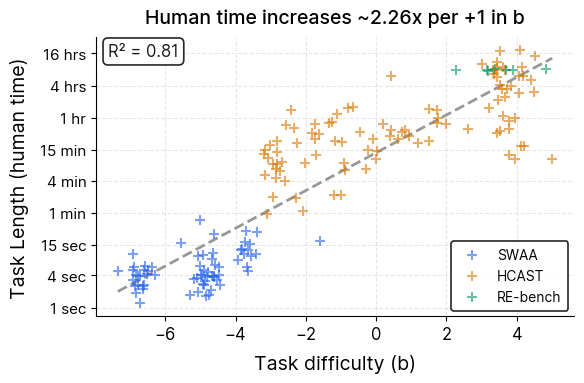

In [9]:
color_map = [
    ('swaa', 'SWAA', '#2563eb'),
    ('hcast', 'HCAST', '#d97706'),
    ('rebench', 'RE-bench', '#059669'),
]

fig, ax = plt.subplots(figsize=(6, 4))

for task_source, task_source_label, color in color_map:
    subset = metr_fit_df[metr_fit_df['task_source'] == task_source]
    ax.scatter(subset['b'], subset['human_minutes'], label=task_source_label,
               color=color, alpha=0.6, marker='+', s=60, linewidth=1.5, zorder=3)

ax.set_yscale('log')
yticks = [1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60]
ytick_labels = ["1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize=11)

x_line = np.linspace(x_b.min(), x_b.max(), 500)
y_line = reg_irt.intercept + reg_irt.slope * x_line
ax.plot(x_line, np.exp(y_line), color="#7f7f7f", linestyle='--', alpha=0.8, linewidth=2, zorder=2)

ax.set_xlabel("Task difficulty (b)", fontsize=14, labelpad=8)
ax.set_ylabel("Task Length (human time)", fontsize=14, labelpad=8)

legend = ax.legend(loc="lower right", frameon=True, fancybox=True, facecolor='white',
                   edgecolor='#1a1a1a', framealpha=0.95, prop={'size': 10})
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_boxstyle("round,pad=0.1,rounding_size=0.2")
ax.grid(True, which="major", linestyle="--", alpha=0.3)
ax.minorticks_off()

r_squared = reg_irt.rvalue ** 2
mult_factor = np.exp(reg_irt.slope)
ax.text(0.025, 0.98, f"R\u00b2 = {r_squared:.2f}", transform=ax.transAxes,
        ha="left", va="top", fontsize=12, color='#1a1a1a',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#1a1a1a', linewidth=1.2, alpha=0.95))
ax.set_title(f"Human time increases ~{mult_factor:.2f}x per +1 in b", fontsize=14, fontweight='medium', pad=10)

fig.tight_layout()
fig.savefig(plots_dir / 'task_difficulty_vs_human_time.pdf', dpi=300)
plt.show()

### Task Length Estimation Distributions

Use the fitted IRT model to predict human completion times for all tasks in SWE-bench, GDPval and MLE-bench. Also, plot the resulting distributions as histograms on a log scale.


In [10]:
# Generate IRT predictions for each benchmark
swebench_predictions = df_irt[(df_irt['base_task'].isin(swebench_task_ids)) & (df_irt['task_source'] == 'swebench') & (df_irt['b'].notna())].copy().reset_index(drop=True)
swebench_predictions['predicted_minutes'] = predict_minutes_from_b(swebench_predictions['b'])
swebench_predictions = swebench_predictions.sort_values('task_id')

mlebench_predictions = df_irt[(df_irt['base_task'].isin(mlebench_task_ids)) & (df_irt['task_source'] == 'mlebench') & (df_irt['b'].notna())].copy().reset_index(drop=True)
mlebench_predictions['predicted_minutes'] = predict_minutes_from_b(mlebench_predictions['b'])
mlebench_predictions = mlebench_predictions.sort_values(['base_task', 'metric'])

gdpval_predictions = df_irt[(df_irt['base_task'].isin(gdpval_task_ids)) & (df_irt['task_source'] == 'gdpval') & (df_irt['b'].notna())].copy().reset_index(drop=True)
gdpval_predictions['predicted_minutes'] = predict_minutes_from_b(gdpval_predictions['b'])
gdpval_predictions = gdpval_predictions.sort_values('task_id')

cybench_predictions = df_irt[(df_irt['task_id'].isin(cybench_task_ids)) & (df_irt['task_source'] == 'cybench') & (df_irt['b'].notna())].copy().reset_index(drop=True)
cybench_predictions['predicted_minutes'] = predict_minutes_from_b(cybench_predictions['b'])
cybench_predictions = cybench_predictions.sort_values('task_id')

print(f"SWE-bench: {len(swebench_predictions)} tasks")
print(f"MLEBench: {len(mlebench_predictions)} task-metrics")
print(f"GDPval: {len(gdpval_predictions)} tasks")
print(f"Cybench: {len(cybench_predictions)} tasks")

SWE-bench: 500 tasks
MLEBench: 114 task-metrics
GDPval: 220 tasks
Cybench: 15 tasks


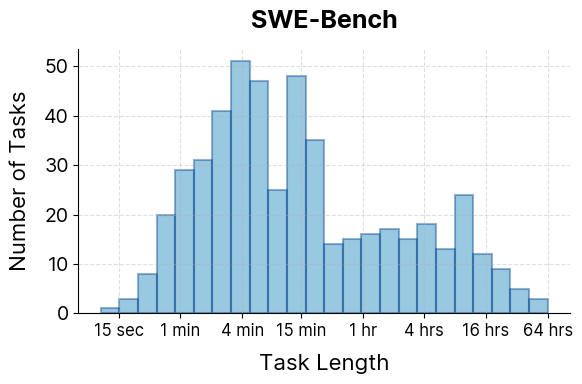

In [11]:
PRIMARY_COLOR = "#0077b6"
POINT_COLOR = "#023e8a"
hist_xticks = [15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60]
hist_xtick_labels = ["15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"]

fig, ax = plt.subplots(figsize=(6, 4))
minutes = swebench_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]
bins = np.geomspace(10/60, 64*60, 25)
ax.hist(minutes, bins=bins, color=PRIMARY_COLOR, alpha=0.4, edgecolor=POINT_COLOR, linewidth=1.5)
ax.set_xscale('log')
ax.set_xticks(hist_xticks)
ax.set_xticklabels(hist_xtick_labels, fontsize=12)
ax.set_xlabel("Task Length", fontsize=16, labelpad=10)
ax.set_ylabel("Number of Tasks", fontsize=16, labelpad=10)
ax.tick_params(axis='y', labelsize=14)
ax.minorticks_off()
ax.set_title("SWE-Bench", fontsize=18, fontweight='bold', pad=15)
ax.grid(True, which="major", linestyle="--", alpha=0.4)
fig.tight_layout()
fig.savefig(plots_dir / "swebench_task_length_estimation.pdf", dpi=300)
plt.show()

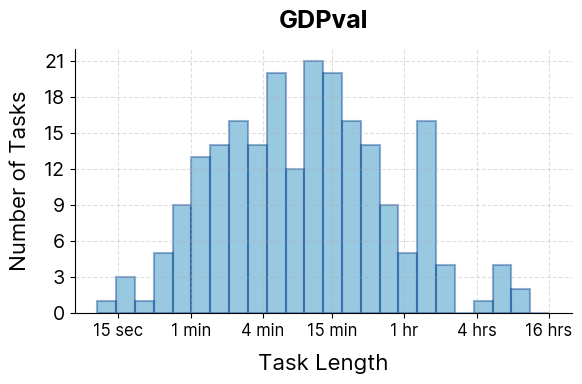

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
minutes = gdpval_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]
bins = np.geomspace(10/60, 16*60, 25)
ax.hist(minutes, bins=bins, color=PRIMARY_COLOR, alpha=0.4, edgecolor=POINT_COLOR, linewidth=1.5)
ax.set_xscale('log')
ax.set_xticks(hist_xticks[:-1])
ax.set_xticklabels(hist_xtick_labels[:-1], fontsize=12)
ax.set_xlabel("Task Length", fontsize=16, labelpad=10)
ax.set_ylabel("Number of Tasks", fontsize=16, labelpad=10)
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.minorticks_off()
ax.set_title("GDPval", fontsize=18, fontweight='bold', pad=15)
ax.grid(True, which="major", linestyle="--", alpha=0.4)
fig.tight_layout()
fig.savefig(plots_dir / "gdpval_task_length_estimation.pdf", dpi=300)
plt.show()

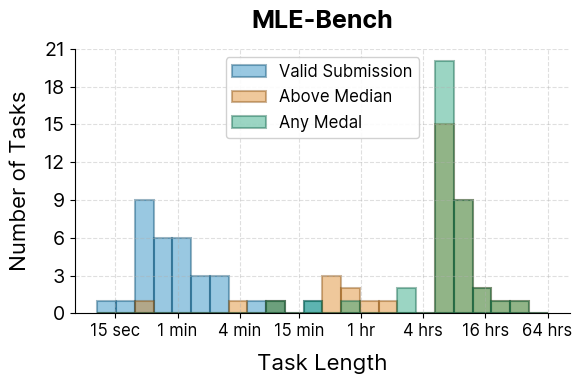

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
mle_metric_specs = [
    ('valid_submission', '#0077b6'),
    ('above_median', '#d97706'),
    ('any_medal', '#059669'),
]
for spec_name, color in mle_metric_specs:
    subset = mlebench_predictions[mlebench_predictions['metric'] == spec_name]
    mins = subset["predicted_minutes"]
    mins = mins[np.isfinite(mins) & (mins > 0)].to_numpy()
    bins = np.geomspace(10/60, 64*60, 25)
    ax.hist(mins, bins=bins, color=color, alpha=0.4,
            edgecolor=darken(color, 0.6), linewidth=1.5, label=spec_name.replace('_', ' ').title())
ax.set_xscale('log')
ax.set_xticks(hist_xticks)
ax.set_xticklabels(hist_xtick_labels, fontsize=12)
ax.set_xlabel("Task Length", fontsize=16, labelpad=10)
ax.set_ylabel("Number of Tasks", fontsize=16, labelpad=10)
ax.tick_params(axis='y', labelsize=14)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.minorticks_off()
ax.set_title("MLE-Bench", fontsize=18, fontweight='bold', pad=15)
ax.legend(loc='upper center', fontsize=12, framealpha=0.9)
ax.grid(True, which="major", linestyle="--", alpha=0.4)
fig.tight_layout()
fig.savefig(plots_dir / "mlebench_task_length_estimation.pdf", dpi=300)
plt.show()

### SWE-bench Time Bucket Classification

Evaluate how well each method predicts the correct time bucket for SWE-bench tasks. Predictions from four methods (Baseline, Gemini 3 Pro, GPT-5.2, and BRIDGE) are compared using accuracy, macro F1 and weighted Cohen's kappa.

Time buckets:
- **<15 min**: Quick fixes
- **15-60 min**: Short tasks
- **1-4 hrs**: Medium tasks
- **>4 hrs**: Long tasks


In [14]:
# IRT bucket classification
swebench_predictions['actual_bucket'] = assign_bucket(swebench_predictions['human_minutes'])
swebench_predictions['predicted_bucket'] = assign_bucket(swebench_predictions['predicted_minutes'])

acc, f1, kappa = compute_bucket_metrics(swebench_predictions['actual_bucket'], swebench_predictions['predicted_bucket'])
print(f"IRT (BRIDGE): Accuracy={acc:.3f}, F1={f1:.3f}, Kappa={kappa:.3f}")

IRT (BRIDGE): Accuracy=0.416, F1=0.284, Kappa=0.231


In [15]:
# Baseline bucket classification
swebench_baseline = df_baseline[
    (df_baseline['task_id'].isin(swebench_task_ids)) &
    (df_baseline['baseline_difficulty_logit'].notna())
].copy()
swebench_baseline['predicted_minutes'] = predict_minutes_baseline(swebench_baseline['baseline_difficulty_logit'])
swebench_baseline['human_minutes'] = swebench_baseline['task_id'].map(all_human_minutes)
swebench_baseline = swebench_baseline[swebench_baseline['human_minutes'].notna()]

swebench_baseline['actual_bucket'] = assign_bucket(swebench_baseline['human_minutes'])
swebench_baseline['predicted_bucket'] = assign_bucket(swebench_baseline['predicted_minutes'])

acc, f1, kappa = compute_bucket_metrics(swebench_baseline['actual_bucket'], swebench_baseline['predicted_bucket'])
print(f"Baseline (Logit Success Rate): Accuracy={acc:.3f}, F1={f1:.3f}, Kappa={kappa:.3f}")

Baseline (Logit Success Rate): Accuracy=0.386, F1=0.165, Kappa=0.115


In [16]:
# Gemini 3 Pro predictions
swebench_gemini = pd.read_json(gemini_swebench_path, lines=True)
normalize_labels = {'15 min - 1 hour': '15-60 min', '<15 min fix': '<15 min', '1-4 hours': '1-4 hrs', '>4 hours': '>4 hrs'}
swebench_gemini['ground_truth_difficulty'] = swebench_gemini['ground_truth_difficulty'].map(normalize_labels)
human_minutes_map = swebench_predictions.set_index('task_id')['human_minutes'].to_dict()
swebench_gemini['human_minutes'] = swebench_gemini['instance_id'].map(human_minutes_map)
swebench_gemini = swebench_gemini.rename(columns={'ground_truth_difficulty': 'time_bucket', 'estimated_minutes': 'predicted_minutes'})

swebench_gemini['actual_bucket'] = assign_bucket(swebench_gemini['human_minutes'])
swebench_gemini['predicted_bucket'] = assign_bucket(swebench_gemini['predicted_minutes'])

acc, f1, kappa = compute_bucket_metrics(swebench_gemini['actual_bucket'], swebench_gemini['predicted_bucket'])
print(f"Gemini 3 Pro: Accuracy={acc:.3f}, F1={f1:.3f}, Kappa={kappa:.3f}")

Gemini 3 Pro: Accuracy=0.360, F1=0.198, Kappa=0.096


In [17]:
# GPT-5.2 predictions
swebench_gpt = pd.read_json(gpt_swebench_path, lines=True)
swebench_gpt['ground_truth_difficulty'] = swebench_gpt['ground_truth_difficulty'].map(normalize_labels)
swebench_gpt['human_minutes'] = swebench_gpt['instance_id'].map(human_minutes_map)
swebench_gpt = swebench_gpt.rename(columns={'ground_truth_difficulty': 'time_bucket', 'estimated_minutes': 'predicted_minutes'})

swebench_gpt['actual_bucket'] = assign_bucket(swebench_gpt['human_minutes'])
swebench_gpt['predicted_bucket'] = assign_bucket(swebench_gpt['predicted_minutes'])

acc, f1, kappa = compute_bucket_metrics(swebench_gpt['actual_bucket'], swebench_gpt['predicted_bucket'])
print(f"GPT-5.2: Accuracy={acc:.3f}, F1={f1:.3f}, Kappa={kappa:.3f}")

GPT-5.2: Accuracy=0.066, F1=0.048, Kappa=0.003


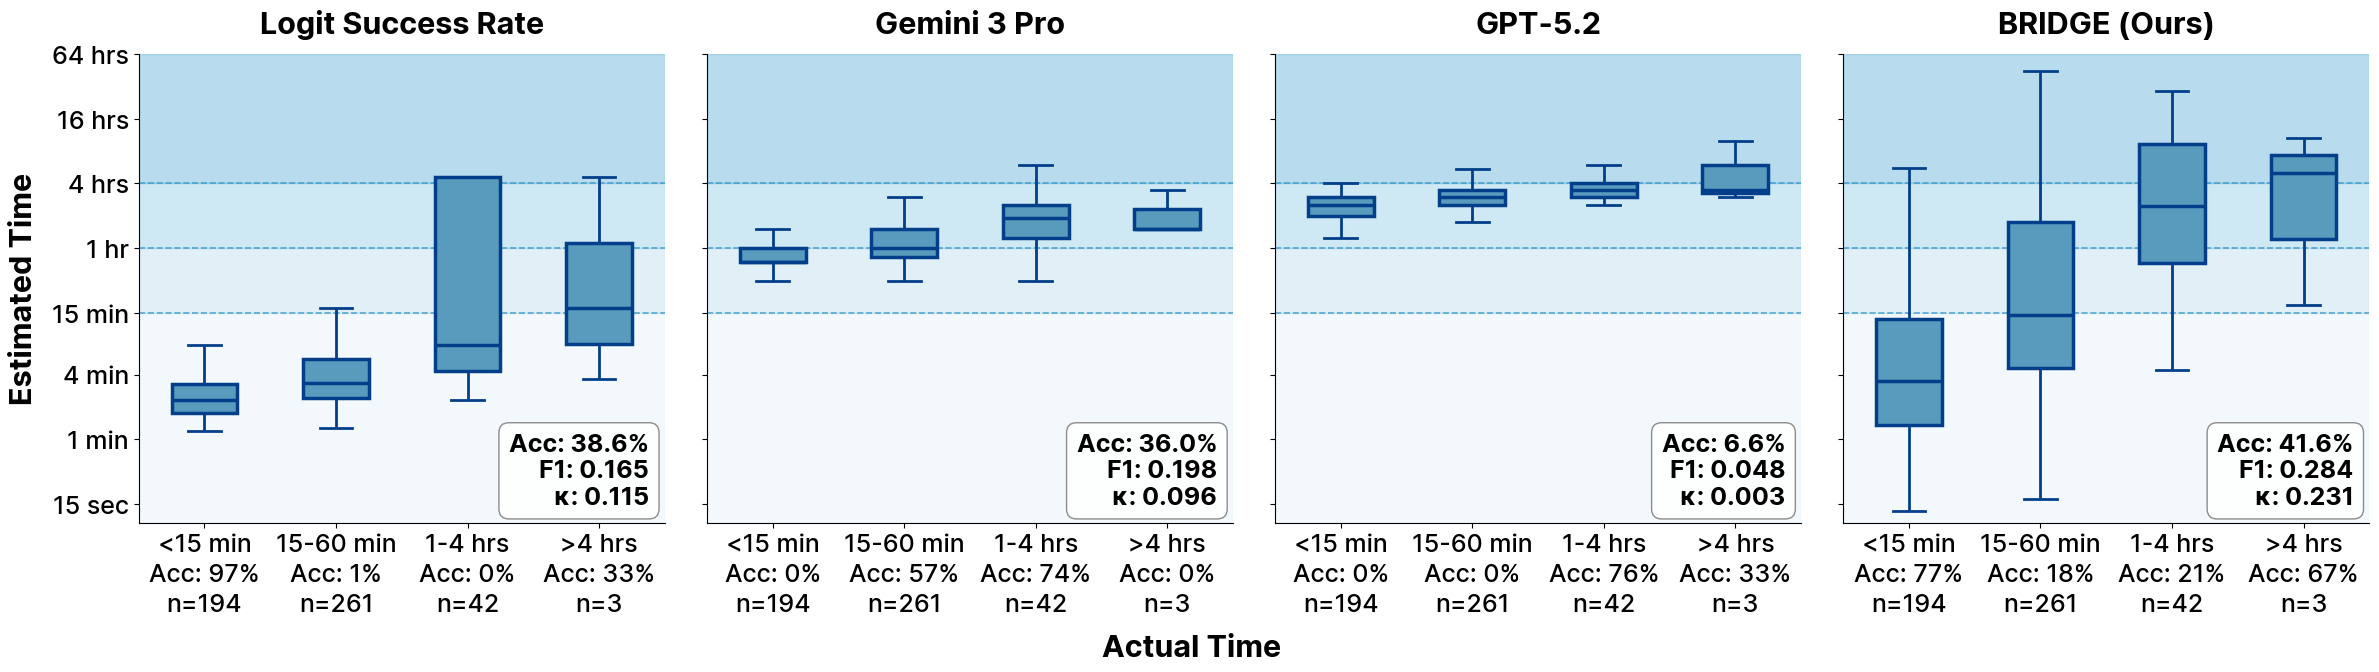

In [18]:
# Combined SWE-bench Time Estimation Boxplot (1x4)

# Colormap setup
custom_blues = mcolors.LinearSegmentedColormap.from_list('custom_blues', ['#e6f3f8', '#90cce6', '#0077b6', '#023e8a'])
base_cmap = custom_blues
region_cmap = truncate_cmap(base_cmap, 0.0, 0.4)
box_cmap = truncate_cmap(base_cmap, 0.5, 1.0)
n_buckets = len(BUCKET_LABELS)
region_colors = [region_cmap(i / (n_buckets - 1)) for i in range(n_buckets)]
box_colors = [box_cmap(0)] * n_buckets
edge_colors = [box_cmap(0.3 / (n_buckets - 1 + 0.3))] * n_buckets
DARK_EDGE = '#023e8a'

plot_configs = [
    ('Logit Success Rate', swebench_baseline),
    ('Gemini 3 Pro', swebench_gemini),
    ('GPT-5.2', swebench_gpt),
    ('BRIDGE (Ours)', swebench_predictions),
]

y_bins = [10/60, 15, 60, 240, 64*60]
xticks_y = [1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60]
xtick_labels_y = ["1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"]

fig, axes = plt.subplots(1, 4, figsize=(24, 7), sharey=True)

for idx, (title, plot_df) in enumerate(plot_configs):
    ax = axes[idx]
    y_true = plot_df['actual_bucket']
    y_pred = plot_df['predicted_bucket']

    accuracy, macro_f1, weighted_kappa = compute_bucket_metrics(y_true, y_pred)

    # Per-bucket stats
    misclass_rates = {}
    bucket_counts = {}
    for label in BUCKET_LABELS:
        bucket_data = plot_df[plot_df['actual_bucket'] == label]
        bucket_counts[label] = len(bucket_data)
        misclass_rates[label] = (bucket_data['actual_bucket'] != bucket_data['predicted_bucket']).sum() / max(len(bucket_data), 1)

    ax.set_yscale('log')
    ax.set_ylim(y_bins[0], y_bins[-1])

    for i, color in enumerate(region_colors):
        ax.axhspan(y_bins[i], y_bins[i+1], color=color, alpha=0.5, zorder=0)
        if i > 0:
            ax.axhline(y=y_bins[i], color=edge_colors[min(i, len(edge_colors)-1)], linestyle='--', linewidth=1.2, alpha=0.8, zorder=1)

    sns.boxplot(
        data=plot_df, x='actual_bucket', y='predicted_minutes', ax=ax, width=0.5,
        order=BUCKET_LABELS, hue='actual_bucket', hue_order=BUCKET_LABELS, palette=box_colors, legend=False,
        linewidth=2.5, medianprops=dict(linewidth=2.5, color=DARK_EDGE),
        boxprops=dict(edgecolor=DARK_EDGE, linewidth=2.5),
        whiskerprops=dict(color=DARK_EDGE, linewidth=2), capprops=dict(color=DARK_EDGE, linewidth=2),
        flierprops=dict(marker='o', markersize=4, alpha=0.6, markeredgecolor='none'), zorder=3,
    )

    xtick_labels_stats = [f'{l}\nAcc: {(1 - misclass_rates[l]) * 100:.0f}%\nn={bucket_counts[l]}' for l in BUCKET_LABELS]
    ax.set_xticks(range(n_buckets))
    ax.set_xticklabels(xtick_labels_stats, fontsize=18, fontweight='medium', linespacing=1.4)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, fontsize=22, fontweight='bold', pad=15)

    stats_text = f'Acc: {accuracy*100:.1f}%\nF1: {macro_f1:.3f}\nκ: {weighted_kappa:.3f}'
    ax.text(0.97, 0.03, stats_text, transform=ax.transAxes, fontsize=18, fontweight='bold',
            va='bottom', ha='right', bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha=0.9))
    ax.minorticks_off()
    ax.grid(False)

axes[0].set_ylabel("Estimated Time", fontsize=22, fontweight='bold', labelpad=10)
axes[0].set_yticks(xticks_y[2:])
axes[0].set_yticklabels(xtick_labels_y[2:], fontsize=18, fontweight='medium')
fig.text(0.5, -0.01, "Actual Time", ha='center', fontsize=22, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(bottom=0.18, top=0.85, wspace=0.08)
fig.savefig(plots_dir / 'swebench_combined_time_estimation_boxplot_1x4.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Cybench Task Length Prediction

Compare predicted task completion times against First Solve Time (FST) ground truth for Cybench CTF challenges. Each method's predictions are evaluated using R-squared (log scale) and the fraction of predictions within a 2x factor of the actual time.


In [19]:
# IRT predictions for Cybench
cybench_predictions['prediction_error'] = cybench_predictions['predicted_minutes'] - cybench_predictions['human_minutes']
cybench_predictions['log_predicted'] = np.log(cybench_predictions['predicted_minutes'])
cybench_predictions['log_actual'] = np.log(cybench_predictions['human_minutes'])

r2_irt_cb = calc_r_squared_log(cybench_predictions['human_minutes'].values, cybench_predictions['predicted_minutes'].values)
within_2x = (cybench_predictions['predicted_minutes'] / cybench_predictions['human_minutes']).between(0.5, 2.0).sum()

print(f"IRT (BRIDGE) - R²: {r2_irt_cb:.4f}, Within 2x: {within_2x}/{len(cybench_predictions)}")

# Load difficulty labels
cybench_records = load_jsonl_records(cybench_results_path)
task_difficulty_map = {}
for record in cybench_records:
    tid = record['task_id']
    if tid not in task_difficulty_map:
        task_difficulty_map[tid] = record.get('difficulty_label', 'unlabelled')
cybench_predictions['difficulty_label'] = cybench_predictions['task_id'].map(task_difficulty_map).fillna('unlabelled')

IRT (BRIDGE) - R²: 0.5318, Within 2x: 14/15


In [20]:
# Baseline predictions for Cybench
cybench_baseline = df_baseline[
    (df_baseline['task_id'].isin(cybench_task_ids)) &
    (df_baseline['task_source'] == 'cybench') &
    (df_baseline['baseline_difficulty_logit'].notna())
].copy().reset_index(drop=True)
cybench_baseline['predicted_minutes'] = predict_minutes_baseline(cybench_baseline['baseline_difficulty_logit'])
cybench_baseline['human_minutes'] = cybench_baseline['task_id'].map(all_human_minutes)
cybench_baseline['difficulty_label'] = cybench_baseline['task_id'].map(task_difficulty_map).fillna('unlabelled')

r2_bl_cb = calc_r_squared_log(cybench_baseline['human_minutes'].values, cybench_baseline['predicted_minutes'].values)
within_2x = (cybench_baseline['predicted_minutes'] / cybench_baseline['human_minutes']).between(0.5, 2.0).sum()
print(f"Baseline - R²: {r2_bl_cb:.4f}, Within 2x: {within_2x}/{len(cybench_baseline)}")

Baseline - R²: -1.4550, Within 2x: 2/15


In [21]:
# Gemini 3 Pro predictions for Cybench
gemini_records = load_jsonl_records(gemini_cybench_path)
gemini_cybench_raw = pd.DataFrame(gemini_records)

cybench_irt_aligned = cybench_predictions.dropna(subset=['predicted_minutes', 'human_minutes']).copy()
cybench_irt_aligned['task_id_norm'] = cybench_irt_aligned['task_id'].apply(normalize_task_id)
gemini_cybench_raw['task_id_norm'] = gemini_cybench_raw['task_id'].apply(
    lambda t: normalize_task_id(t, strip_difficulty=True, append_suffix='unguided'))

alignment_df = cybench_irt_aligned[['task_id', 'task_id_norm', 'human_minutes', 'difficulty_label']].merge(
    gemini_cybench_raw[['task_id_norm', 'fst_minutes', 'estimated_minutes']], on='task_id_norm', how='inner')
alignment_df = alignment_df.dropna(subset=['estimated_minutes', 'human_minutes'])
alignment_df = alignment_df[(alignment_df['estimated_minutes'] > 0) & (alignment_df['human_minutes'] > 0)]

cybench_gemini = alignment_df.copy()
cybench_gemini['predicted_minutes'] = cybench_gemini['estimated_minutes']

r2_gm_cb = calc_r_squared_log(cybench_gemini['human_minutes'].values, cybench_gemini['predicted_minutes'].values)
within_2x = (cybench_gemini['predicted_minutes'] / cybench_gemini['human_minutes']).between(0.5, 2.0).sum()
print(f"Gemini 3 Pro - R²: {r2_gm_cb:.4f}, Within 2x: {within_2x}/{len(cybench_gemini)}")

# GPT-5.2 predictions for Cybench
gpt_records = load_jsonl_records(gpt_cybench_path)
gpt_cybench_raw = pd.DataFrame(gpt_records)
gpt_cybench_raw['task_id_norm'] = gpt_cybench_raw['task_id'].apply(
    lambda t: normalize_task_id(t, strip_difficulty=True, append_suffix='unguided'))

alignment_df = cybench_irt_aligned[['task_id', 'task_id_norm', 'human_minutes', 'difficulty_label']].merge(
    gpt_cybench_raw[['task_id_norm', 'fst_minutes', 'estimated_minutes']], on='task_id_norm', how='inner')
alignment_df = alignment_df.dropna(subset=['estimated_minutes', 'human_minutes'])
alignment_df = alignment_df[(alignment_df['estimated_minutes'] > 0) & (alignment_df['human_minutes'] > 0)]

cybench_gpt = alignment_df.copy()
cybench_gpt['predicted_minutes'] = cybench_gpt['estimated_minutes']

r2_gp_cb = calc_r_squared_log(cybench_gpt['human_minutes'].values, cybench_gpt['predicted_minutes'].values)
within_2x = (cybench_gpt['predicted_minutes'] / cybench_gpt['human_minutes']).between(0.5, 2.0).sum()
print(f"GPT-5.2 - R²: {r2_gp_cb:.4f}, Within 2x: {within_2x}/{len(cybench_gpt)}")

Gemini 3 Pro - R²: 0.3044, Within 2x: 6/15
GPT-5.2 - R²: -0.2946, Within 2x: 3/15


R²: Baseline=-1.455, Gemini=0.304, GPT=-0.295, IRT=0.532


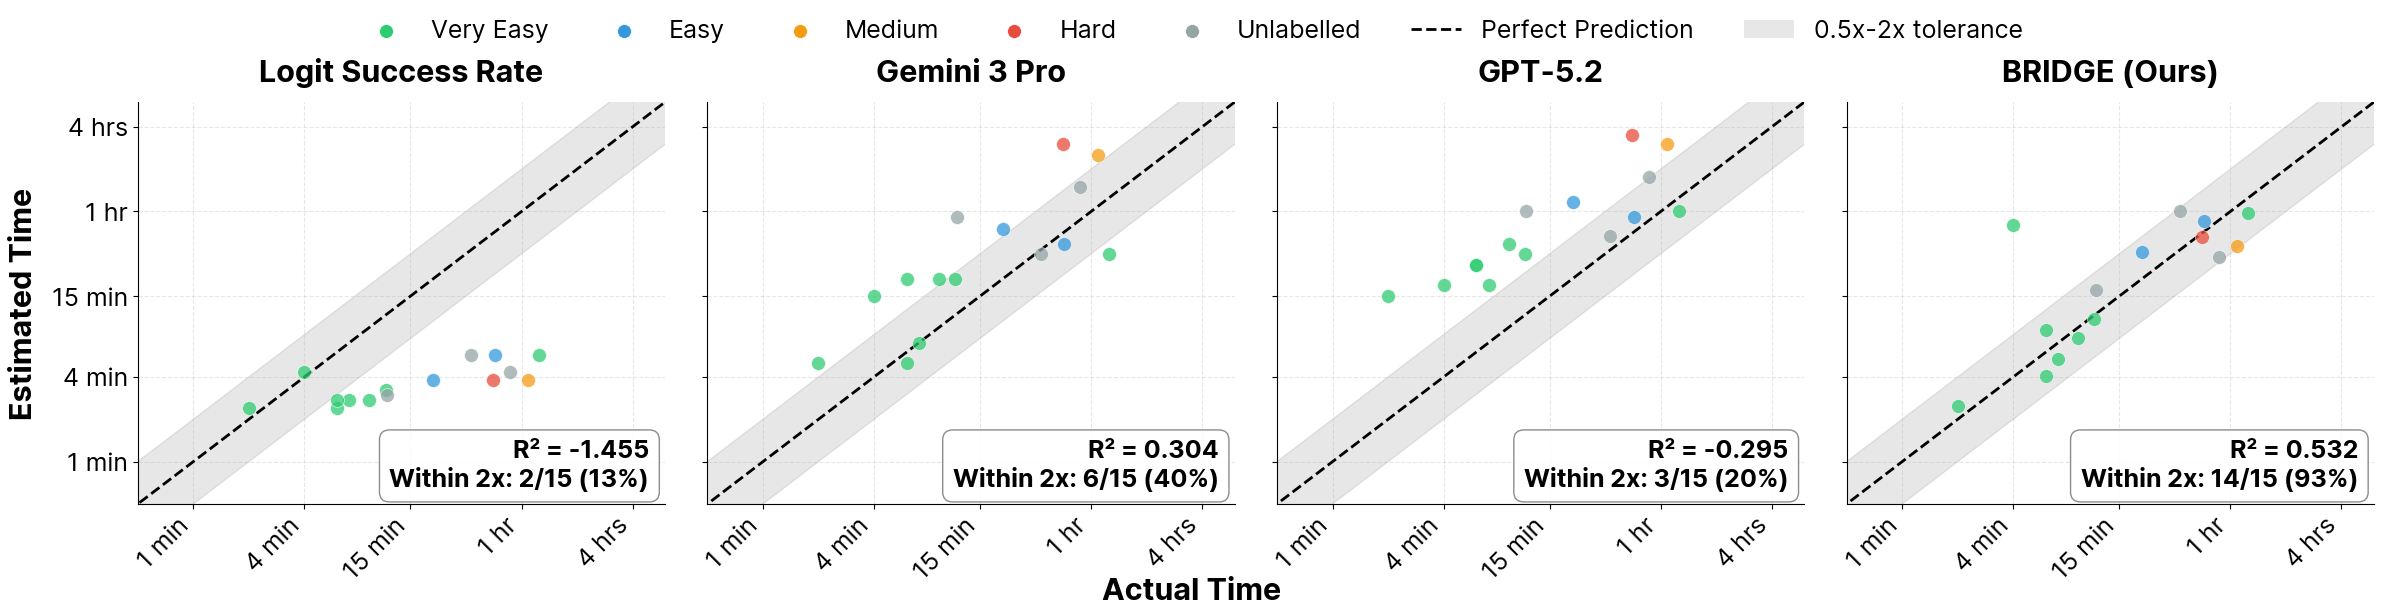

In [22]:
# Combined Cybench scatter plot (1x4)

r2_baseline = calc_r_squared_log(cybench_baseline['human_minutes'].values, cybench_baseline['predicted_minutes'].values)
r2_gemini = calc_r_squared_log(cybench_gemini['human_minutes'].values, cybench_gemini['predicted_minutes'].values)
r2_gpt = calc_r_squared_log(cybench_gpt['human_minutes'].values, cybench_gpt['predicted_minutes'].values)
r2_irt = calc_r_squared_log(cybench_predictions['human_minutes'].values, cybench_predictions['predicted_minutes'].values)

print(f"R²: Baseline={r2_baseline:.3f}, Gemini={r2_gemini:.3f}, GPT={r2_gpt:.3f}, IRT={r2_irt:.3f}")

plot_configs = [
    ('Logit Success Rate', cybench_baseline, r2_baseline),
    ('Gemini 3 Pro', cybench_gemini, r2_gemini),
    ('GPT-5.2', cybench_gpt, r2_gpt),
    ('BRIDGE (Ours)', cybench_predictions, r2_irt),
]

time_ticks = [1, 4, 15, 60, 4*60]
time_tick_labels = ["1 min", "4 min", "15 min", "1 hr", "4 hrs"]
axis_min = time_ticks[0] * 0.5
axis_max = time_ticks[-1] * 1.5
line_x = np.logspace(np.log10(axis_min * 0.001), np.log10(axis_max * 1000), 500)

fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)

for idx, (title, plot_df, r2) in enumerate(plot_configs):
    ax = axes[idx]
    actual = plot_df['human_minutes'].values
    predicted = plot_df['predicted_minutes'].values
    error_ratio = predicted / actual
    within_2x_count = np.sum((error_ratio >= 0.5) & (error_ratio <= 2.0))
    within_2x_pct = within_2x_count / len(plot_df) * 100

    ax.fill_between(line_x, line_x * 0.5, line_x * 2.0, alpha=0.20, color='#888888')
    ax.plot(line_x, line_x, 'k--', linewidth=2)

    for diff in DIFFICULTY_ORDER:
        diff_mask = plot_df['difficulty_label'] == diff
        if diff_mask.sum() > 0:
            ax.scatter(plot_df.loc[diff_mask, 'human_minutes'], plot_df.loc[diff_mask, 'predicted_minutes'],
                       c=DIFFICULTY_COLORS[diff], marker='o', alpha=0.75, s=100, edgecolors='white',
                       linewidths=0.5, zorder=3, label=DIFFICULTY_DISPLAY[diff])

    ax.set_title(title, fontsize=22, fontweight='bold', pad=15)
    stats_text = f'R² = {r2:.3f}\nWithin 2x: {within_2x_count}/{len(plot_df)} ({within_2x_pct:.0f}%)'
    ax.text(0.97, 0.03, stats_text, transform=ax.transAxes, fontsize=18, fontweight='bold',
            va='bottom', ha='right', bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha=0.9))

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_tick_labels, fontsize=18, rotation=45, ha='right')
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(True, which='major', linestyle='--', alpha=0.3)
    ax.minorticks_off()

axes[0].set_ylabel("Estimated Time", fontsize=22, fontweight='bold', labelpad=10)
axes[0].set_yticks(time_ticks)
axes[0].set_yticklabels(time_tick_labels, fontsize=18)
fig.text(0.5, 0.02, "Actual Time", ha='center', fontsize=22, fontweight='bold')

# Legend
handles, labels = [], []
for diff in DIFFICULTY_ORDER:
    if any((df['difficulty_label'] == diff).any() for _, df, _ in plot_configs):
        handles.append(plt.scatter([], [], c=DIFFICULTY_COLORS[diff], s=100, edgecolors='white', linewidths=0.5))
        labels.append(DIFFICULTY_DISPLAY[diff])
handles.append(Line2D([0], [0], color='black', linestyle='--', linewidth=2))
labels.append('Perfect Prediction')
handles.append(Patch(facecolor='#888888', alpha=0.2))
labels.append('0.5x-2x tolerance')
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.025), ncol=len(handles), fontsize=18, frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.18, top=0.85, wspace=0.08)
fig.savefig(plots_dir / 'cybench_combined_time_estimation_1x4.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Success Probability vs Task Length

Compute the 2PL IRT success probability for frontier models (best per 5-month release bucket) across all tasks and plot how success probability decays with increasing task length for each benchmark.


In [23]:
def success_prob(ability, a, b):
    """Calculate success probability using 2PL IRT model."""
    exp_term = np.exp(-a * (ability - b))
    return 1 / (1 + exp_term)

# Load model abilities
abilities_df = pd.read_csv(abilities_path)
model_df = abilities_df.copy()
model_df['release_time'] = pd.to_datetime(model_df['release_time'], errors='coerce')
model_df = model_df.dropna(subset=['release_time'])
model_df = model_df.rename(columns={'subject_id': 'model_name'})

# Create 5-month buckets
bucket_span_months = 5
release_month_numbers = (model_df['release_time'].dt.year * 12 + (model_df['release_time'].dt.month - 1)).astype(int)
anchor_month_number = release_month_numbers.min()
bucket_indices = ((release_month_numbers - anchor_month_number) // bucket_span_months).astype(int)
bucket_month_numbers = anchor_month_number + bucket_indices * bucket_span_months
bucket_years = bucket_month_numbers // 12
bucket_month_in_year = (bucket_month_numbers % 12) + 1
model_df['bucket_start'] = pd.to_datetime({'year': bucket_years, 'month': bucket_month_in_year, 'day': 1})

# Select best model per bucket
bucketed_models_df = model_df.sort_values('ability', ascending=False).groupby('bucket_start', as_index=False).first().sort_values('bucket_start')

# Create METR predictions
irt_params_df = pd.read_csv(irt_params_path, index_col=0).reset_index(names='task_id')
metr_df = pd.DataFrame(load_jsonl_records(all_runs_path))
metr_tasks = metr_df[metr_df['alias'] != 'human'][['task_id', 'human_minutes', 'task_source']].drop_duplicates(subset='task_id')
metr_predictions = metr_tasks.merge(irt_params_df[['task_id', 'a', 'b']], on='task_id', how='inner')
metr_predictions['predicted_minutes'] = metr_predictions['b'].apply(lambda x: predict_minutes_from_b(x))
metr_predictions = metr_predictions.dropna(subset=['a', 'b', 'predicted_minutes'])

# Generate success probability data for bucketed models
model_to_success_prob = []
task_sources = [("metr", metr_predictions), ("swebench", swebench_predictions),
                ("cybench", cybench_predictions), ("mlebench", mlebench_predictions), ("gdpval", gdpval_predictions)]

for _, row in bucketed_models_df.iterrows():
    for task_source_name, task_source_df in task_sources:
        for _, task_row in task_source_df.iterrows():
            prob = success_prob(row['ability'], task_row['a'], task_row['b'])
            model_to_success_prob.append({
                "model_name": row['model_name'], "release_time": row['release_time'],
                "bucket_start": row['bucket_start'], "task_id": task_row['task_id'],
                "task_source": task_source_name, "success_prob": prob,
                "predicted_minutes": task_row['predicted_minutes'],
                "difficulty_b": task_row['b'], "discrimination_a": task_row['a'], "ability": row['ability'],
            })

model_to_success_prob_df = pd.DataFrame(model_to_success_prob)
model_to_success_prob_df = model_to_success_prob_df[model_to_success_prob_df['model_name'] != 'gpt2']
print(f"Success probability data: {len(model_to_success_prob_df)} rows")
print(f"Models: {model_to_success_prob_df['model_name'].nunique()}")
print(f"Buckets: {model_to_success_prob_df['bucket_start'].nunique()}")

Success probability data: 8152 rows
Models: 8
Buckets: 8


In [24]:
def get_best_model_per_bucket(df):
    """For each bucket_start, find the model with the highest average success_prob."""
    avg_success = df.groupby(['bucket_start', 'model_name'])['success_prob'].mean().reset_index()
    avg_success.columns = ['bucket_start', 'model_name', 'avg_success_prob']
    idx_best = avg_success.groupby('bucket_start')['avg_success_prob'].idxmax()
    best_models_df = avg_success.loc[idx_best]
    best_models = dict(zip(best_models_df['bucket_start'], best_models_df['model_name']))
    filtered_df = df.merge(best_models_df[['bucket_start', 'model_name']], on=['bucket_start', 'model_name'], how='inner')
    return filtered_df, best_models


def plot_success_prob_grid(df, threshold=0.5, column_name="predicted_minutes", prefix="grid", base_dir=BASE_DIR):
    """Create a 1x5 grid showing success probability trends for different task sources."""
    task_sources = ['metr', 'swebench', 'mlebench', 'gdpval', None]
    task_source_names = {'metr': 'METR', 'swebench': 'SWE-bench', 'mlebench': 'MLE-bench', 'gdpval': 'GDPval', None: 'All Tasks'}

    _, best_models_global = get_best_model_per_bucket(df)
    bucket_starts = sorted(df['bucket_start'].unique())
    n_buckets = len(bucket_starts)

    fig, axes = plt.subplots(1, 5, figsize=(24, 7), sharey=True)
    base_cmap = plt.get_cmap('Blues')
    cmap = truncate_cmap(base_cmap, 0.35, 1.0)
    window = 15

    for col_idx, task_source in enumerate(task_sources):
        ax = axes[col_idx]
        subset_df = df[df['task_source'] == task_source].copy() if task_source else df.copy()
        avg_a = subset_df['discrimination_a'].mean()
        avg_b = subset_df['difficulty_b'].mean()

        if len(subset_df) > 0:
            filtered_df, best_models = get_best_model_per_bucket(subset_df)
        else:
            filtered_df, best_models = subset_df, {}

        ax.axhline(threshold, color="#7f7f7f", linestyle="--", linewidth=1.5, alpha=0.8)
        value_at_threshold = []

        for i, bucket_start in enumerate(bucket_starts):
            subset = filtered_df[filtered_df['bucket_start'] == bucket_start].sort_values(column_name)
            if len(subset) == 0:
                continue

            logits = subset['discrimination_a'] * (subset['ability'] - subset['difficulty_b'])
            mean_logit = logits.rolling(window=window, center=True, min_periods=5).mean()
            std_logit = logits.rolling(window=window, center=True, min_periods=5).std().fillna(0)
            count = logits.rolling(window=window, center=True, min_periods=5).count()
            se_logit = std_logit / np.sqrt(count)

            x = subset[column_name].to_numpy()
            y = (1 / (1 + np.exp(-mean_logit))).to_numpy()
            y_lower = (1 / (1 + np.exp(-(mean_logit - se_logit)))).to_numpy()
            y_upper = (1 / (1 + np.exp(-(mean_logit + se_logit)))).to_numpy()

            color = cmap(i / (n_buckets - 1)) if n_buckets > 1 else cmap(0.5)
            model_name = best_models.get(bucket_start, bucket_start.strftime('%Y-%m'))
            ax.plot(x, y, color=color, label=model_name, linewidth=2.5)
            ax.fill_between(x, y_lower, y_upper, color=color, alpha=0.15, linewidth=0)

            mask = ~np.isnan(y)
            x_valid, y_valid = x[mask], y[mask]
            if len(x_valid) == 0 or y_valid.max() < threshold:
                continue

            idx = np.argmin(np.abs(y_valid - threshold))
            value_star = x_valid[idx]
            value_at_threshold.append((bucket_start, value_star))
            ax.scatter(value_star, threshold, color=color, edgecolor="black", s=60, zorder=5, linewidths=1.5)
            ax.axvline(value_star, ymin=0, ymax=threshold, color=color, linestyle="--", linewidth=2, alpha=0.6)

        if column_name != "difficulty_b":
            ax.set_xscale('log')
            sp_xticks = [15/60, 1, 4, 15, 60, 4*60, 16*60]
            sp_xtick_labels = ["15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs"]
            ax.set_xticks(sp_xticks)
            ax.set_xticklabels(sp_xtick_labels, fontsize=20, rotation=45, ha='right')
            ax.set_xlim(4/60, 20*60)

        ax.tick_params(axis='y', labelsize=22)
        title = task_source_names[task_source]
        ax.set_title(title, fontsize=24, fontweight='bold', pad=60, y=0.98)

        if value_at_threshold:
            _, latest_value = max(value_at_threshold, key=lambda x: x[0])
            if latest_value < 1:
                val_str = f"{latest_value * 60:.0f} sec"
            elif latest_value < 60:
                val_str = f"{latest_value:.0f} min"
            else:
                val_str = f"{latest_value / 60:.1f} hr"
            subtitle = f"Frontier: {val_str}\nAvg a: {avg_a:.2f}, Avg b: {avg_b:.2f}"
        else:
            subtitle = f"Avg a: {avg_a:.2f}, Avg b: {avg_b:.2f}"
        ax.text(0.5, 1.02, subtitle, transform=ax.transAxes, fontsize=16, ha='center', va='bottom',
                weight='bold', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        ax.grid(True, which="major", linestyle="--", alpha=0.4)
        ax.minorticks_off()
        ax.set_ylim(-0.02, 1.05)

    axes[0].set_ylabel("Success Probability", fontsize=22, fontweight='bold', labelpad=10)
    xlabel = "Task Length" if column_name != "difficulty_b" else "Task Difficulty"
    fig.text(0.5, -0.02, xlabel, ha='center', fontsize=22, fontweight='bold')

    # Colorbar
    norm = plt.Normalize(vmin=-0.5, vmax=n_buckets - 0.5)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.05, 0.95, 0.9, 0.02])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    ticks = np.arange(n_buckets)
    cbar.set_ticks(ticks)
    tick_labels = []
    for b in bucket_starts:
        date_str = b.strftime('%Y-%m')
        mn = best_models_global.get(b, "")
        tick_labels.append(f"{date_str}\n({MODEL_MAPS.get(mn, mn)})" if mn else date_str)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.xaxis.set_ticks_position('top')

    plt.tight_layout()
    plt.subplots_adjust(top=0.75, bottom=0.15, wspace=0.08)
    title_suffix = "task_difficulty" if column_name == "difficulty_b" else "task_length"
    fig.savefig(base_dir / "plots" / f"{prefix}_grid_vs_{title_suffix}_threshold_{threshold:.2f}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

/var/folders/rs/m2mywrv52bl5mvyt484882d80000gn/T/ipykernel_92459/697858561.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


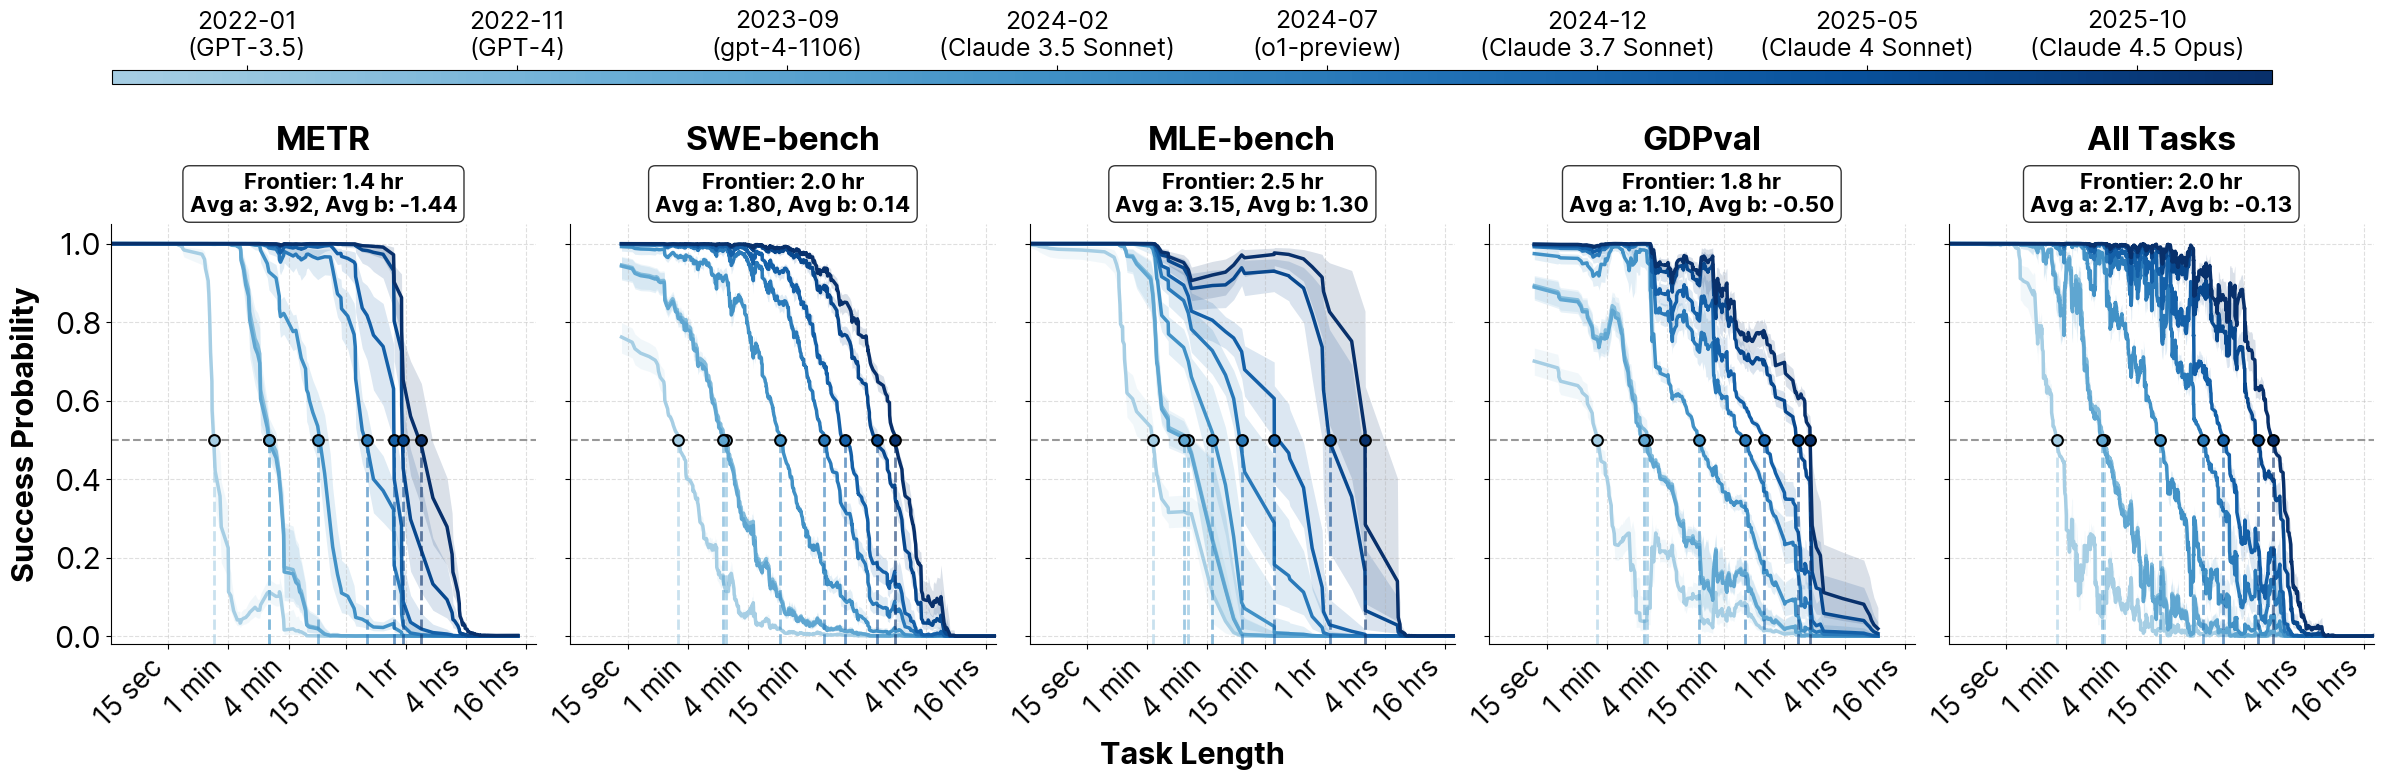

/var/folders/rs/m2mywrv52bl5mvyt484882d80000gn/T/ipykernel_92459/697858561.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


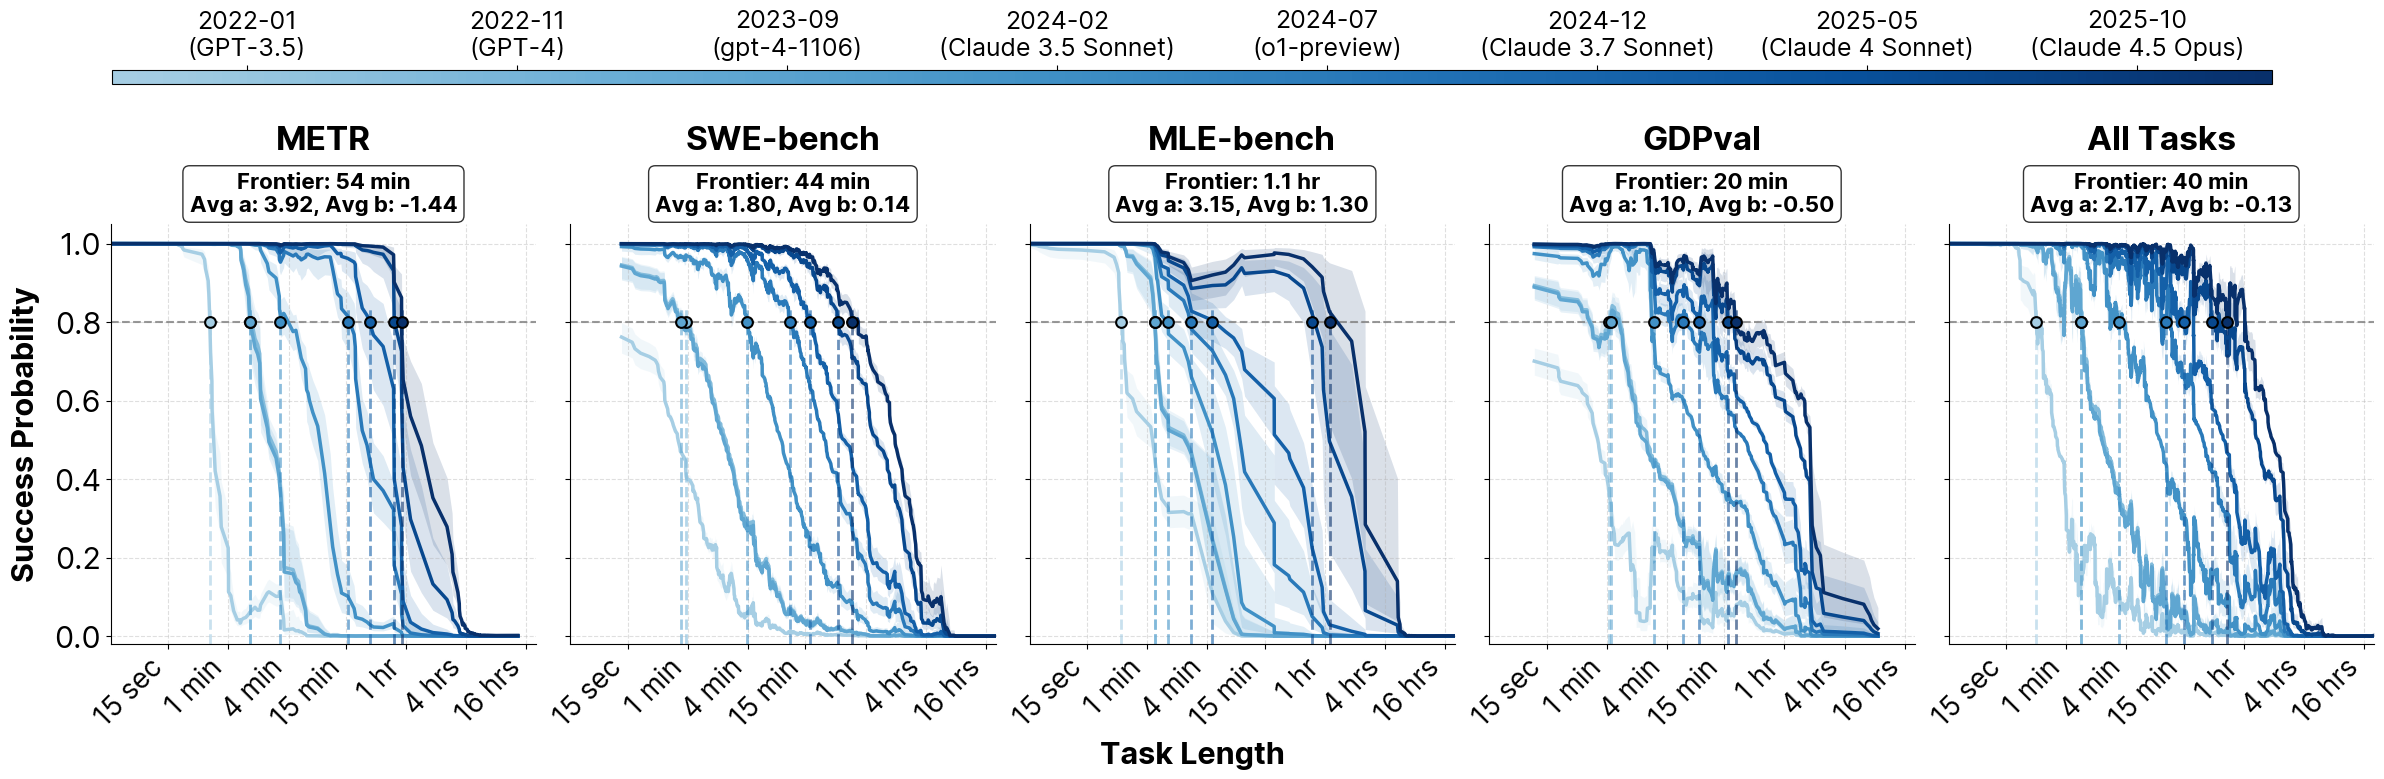

In [25]:
for threshold in [0.5, 0.8]:
    plot_success_prob_grid(
        df=model_to_success_prob_df,
        threshold=threshold,
        column_name='predicted_minutes',
        prefix='all_sources'
    )

### Task Length Frontier Forecasting

Estimate how quickly the maximum task length that frontier models can handle is growing over time. We fit a linear trend to frontier model abilities and derive a doubling time (with bootstrap confidence intervals) at both 50% and 80% success rate thresholds.

In [26]:
# Generate all-models success probability data (not just bucketed)
all_models_to_success_prob = []
for _, row in model_df.iterrows():
    for task_source_name, task_source_df in task_sources:
        for _, task_row in task_source_df.iterrows():
            prob = success_prob(row['ability'], task_row['a'], task_row['b'])
            all_models_to_success_prob.append({
                "model_name": row['model_name'], "release_time": row['release_time'],
                "bucket_start": row['bucket_start'], "task_id": task_row['task_id'],
                "task_source": task_source_name, "success_prob": prob,
                "predicted_minutes": task_row['predicted_minutes'],
                "difficulty_b": task_row['b'], "discrimination_a": task_row['a'], "ability": row['ability'],
            })

all_models_to_success_prob_df = pd.DataFrame(all_models_to_success_prob)
all_models_to_success_prob_df = all_models_to_success_prob_df[all_models_to_success_prob_df['model_name'] != 'gpt2']
print(f"All-models success probability data: {len(all_models_to_success_prob_df)} rows")

All-models success probability data: 36684 rows


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


P50 - Slope: 0.1486 [0.1253, 0.1857]
P50 - Doubling time: 5.7 months [4.6, 6.8]


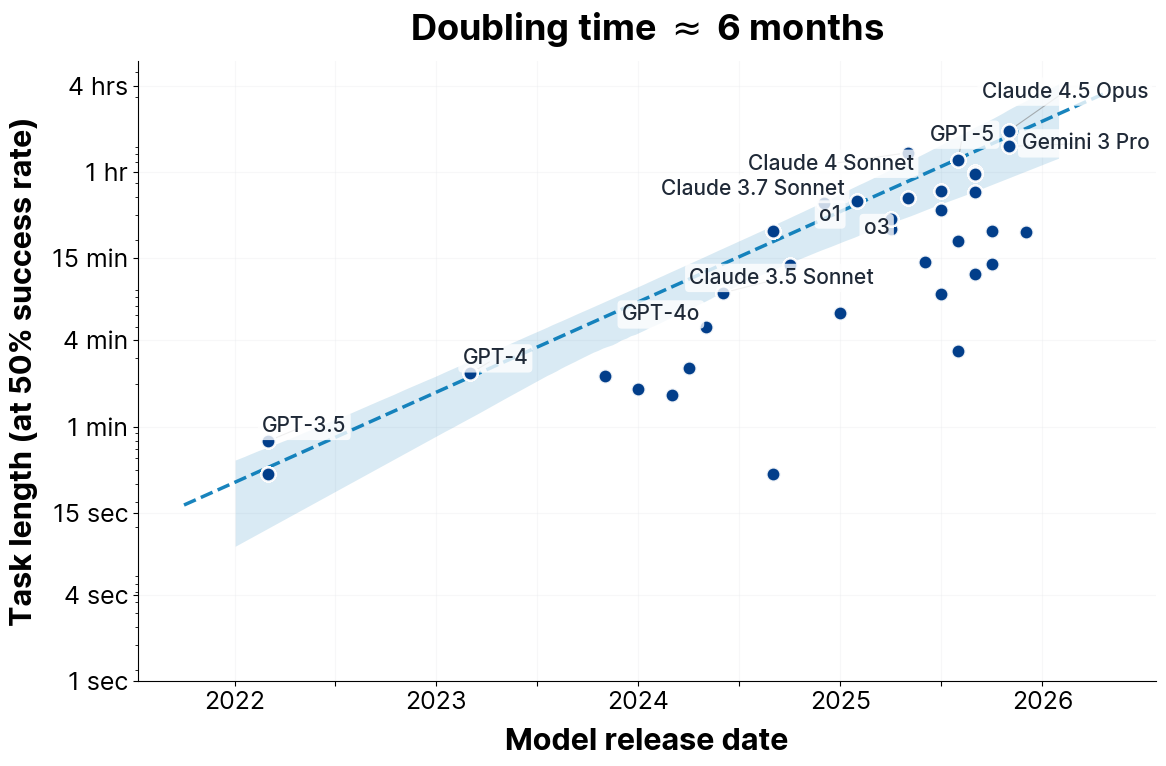

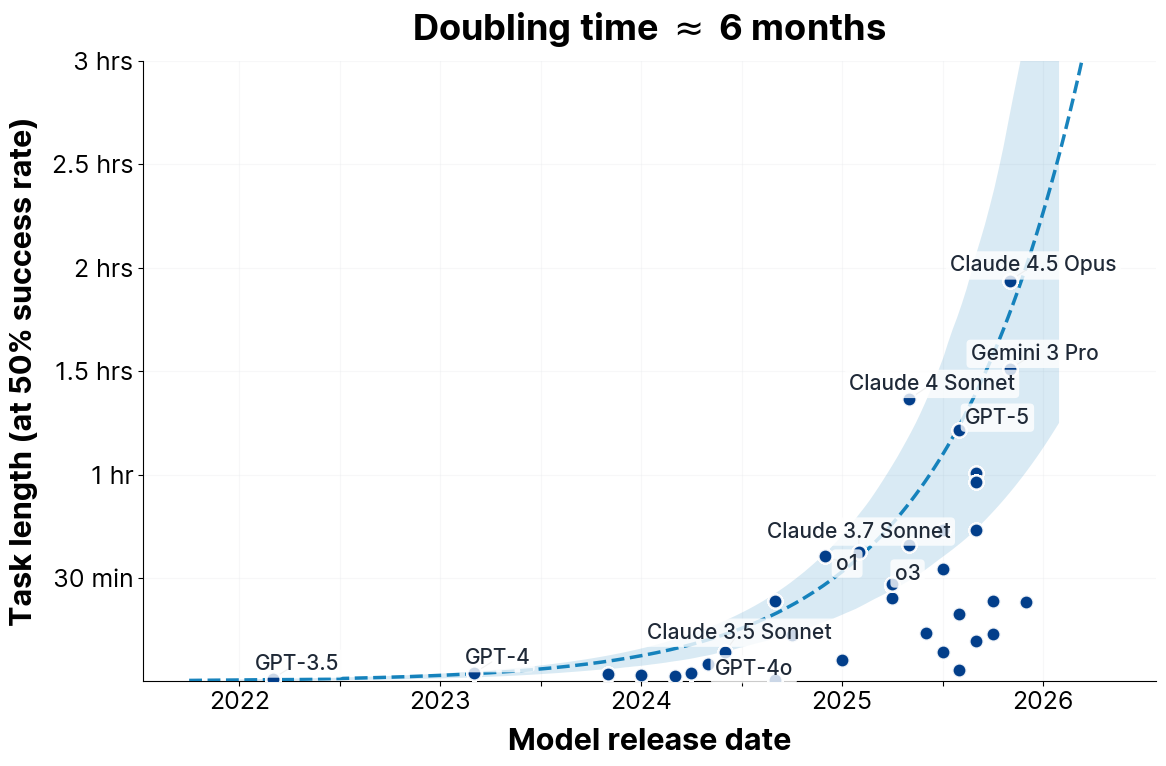

In [27]:
def plot_task_length_forecasts_p50(model_ability_df, model_maps=MODEL_MAPS, n_bootstrap=500, prefix="ability_forecast", color="blue"):
    """Plot task length forecasts at 50% success rate using model ability directly."""
    fit_df = model_ability_df.copy()
    fit_df["release_time"] = pd.to_datetime(fit_df["release_time"])
    fit_df["release_months_norm"] = fit_df["release_time"].dt.year * 12 + (fit_df["release_time"].dt.month - 1).astype(float)
    fit_df['predicted_minutes'] = predict_minutes_from_b(fit_df['ability'].to_numpy())

    # Select frontier models (Pareto optimal)
    fit_sorted = fit_df.sort_values("release_time")
    frontier_rows, best_so_far = [], -np.inf
    for _, row in fit_sorted.iterrows():
        if row["ability"] > best_so_far + 0.2:
            frontier_rows.append(row)
            best_so_far = row["ability"]
    frontier_df = pd.DataFrame(frontier_rows).reset_index(drop=True)

    # Linear regression on frontier
    x = frontier_df["release_months_norm"].to_numpy().astype(float)
    y = frontier_df['ability'].to_numpy().astype(float)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    n = len(x)
    reg_ = stats.linregress(x, y)
    x_fit = np.linspace(2021 * 12 + 9, 2026 * 12 + 4, 200)
    y_fit = reg_.intercept + reg_.slope * x_fit

    # Bootstrap CI
    rng = np.random.default_rng(42)
    bootstrap_fits = np.zeros((n_bootstrap, len(x_fit)))
    bootstrap_slopes = np.zeros(n_bootstrap)
    for i in range(n_bootstrap):
        indices = rng.choice(n, size=n, replace=True)
        reg_boot = stats.linregress(x[indices], y[indices])
        bootstrap_fits[i] = reg_boot.intercept + reg_boot.slope * x_fit
        bootstrap_slopes[i] = reg_boot.slope

    y_ci_lower = np.percentile(bootstrap_fits, 2.5, axis=0)
    y_ci_upper = np.percentile(bootstrap_fits, 97.5, axis=0)
    slope_ci = [np.percentile(bootstrap_slopes, 2.5), np.percentile(bootstrap_slopes, 97.5)]

    delta_theta = np.log(2.0) / np.log(2.26)
    doubling_months = delta_theta / reg_.slope
    doubling_ci = [delta_theta / slope_ci[1], delta_theta / slope_ci[0]]
    print(f"P50 - Slope: {reg_.slope:.4f} [{slope_ci[0]:.4f}, {slope_ci[1]:.4f}]")
    print(f"P50 - Doubling time: {doubling_months:.1f} months [{doubling_ci[0]:.1f}, {doubling_ci[1]:.1f}]")

    # Colors
    PRIMARY = "#0077b6" if color == "blue" else "#059669"
    POINT = "#023e8a" if color == "blue" else "#047857"

    x_data_min, x_data_max = fit_df["release_months_norm"].min(), fit_df["release_months_norm"].max()
    ci_mask = (x_fit >= x_data_min - 2) & (x_fit <= x_data_max + 2)
    date_xticks = [2022*12, 2022*12+6, 2023*12, 2023*12+6, 2024*12, 2024*12+6, 2025*12, 2025*12+6, 2026*12]
    date_labels = ["2022", "", "2023", "", "2024", "", "2025", "", "2026"]

    plt.rcParams.update({'font.size': 18, 'axes.titlesize': 26, 'axes.labelsize': 22, 'xtick.labelsize': 18, 'ytick.labelsize': 18})

    for scale in ['log', 'linear']:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(fit_df["release_months_norm"], fit_df["predicted_minutes"], s=100, color=POINT, edgecolors='white', linewidths=1.5, alpha=0.9, zorder=4)

        texts = []
        for mn, ml in model_maps.items():
            if mn not in fit_df["model_name"].values:
                continue
            r = fit_df[fit_df["model_name"] == mn].iloc[0]
            texts.append(ax.text(r["release_months_norm"], r["predicted_minutes"], ml, fontsize=15, fontweight='medium', ha="center", va="bottom", color='#1f2937', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8), zorder=10))

        y_fit_min = predict_minutes_from_b(y_fit)
        ax.plot(x_fit, y_fit_min, color=PRIMARY, linestyle="--", linewidth=2.5, alpha=0.9, zorder=3)
        ax.fill_between(x_fit[ci_mask], predict_minutes_from_b(y_ci_lower[ci_mask]), predict_minutes_from_b(y_ci_upper[ci_mask]), color=PRIMARY, alpha=0.15, linewidth=0, zorder=1)

        ax.set_xticks(date_xticks)
        ax.set_xticklabels(date_labels)
        ax.set_xlabel("Model release date", fontsize=22, fontweight='bold', labelpad=10)
        ax.set_ylabel("Task length (at 50% success rate)", fontsize=22, fontweight='bold', labelpad=10)
        ax.set_title(f"Doubling time $\\approx$ {doubling_months:.0f} months", fontsize=26, fontweight='bold', pad=15)
        ax.grid(True, which="major", linestyle="-", alpha=0.3, color='#e5e7eb', zorder=0)
        ax.set_axisbelow(True)
        ax.minorticks_off()

        if scale == 'log':
            ax.set_yscale('log')
            yticks = [1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60]
            ax.set_yticks(yticks)
            ax.set_yticklabels(["1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs"])
        else:
            ax.set_yticks([30, 60, 90, 120, 150, 180])
            ax.set_yticklabels(["30 min", "1 hr", "1.5 hrs", "2 hrs", "2.5 hrs", "3 hrs"])
            ax.set_ylim(0, 180)

        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.6, lw=0.8, shrinkA=5, shrinkB=5), 
                    expand_points=(2.0, 2.0), expand_text=(1.5, 1.5), force_points=(1.0, 1.0), force_text=(0.8, 0.8), only_move={'points': 'y', 'texts': 'xy'})
        fig.tight_layout()
        fig.savefig(plots_dir / f"{prefix}_{scale}_scale_p50.pdf", dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()


plot_task_length_forecasts_p50(all_models_to_success_prob_df, n_bootstrap=2000)

P80 - Slope: 0.1375 [0.1065, 0.2390]
P80 - Doubling time: 6.2 months [3.6, 8.0]


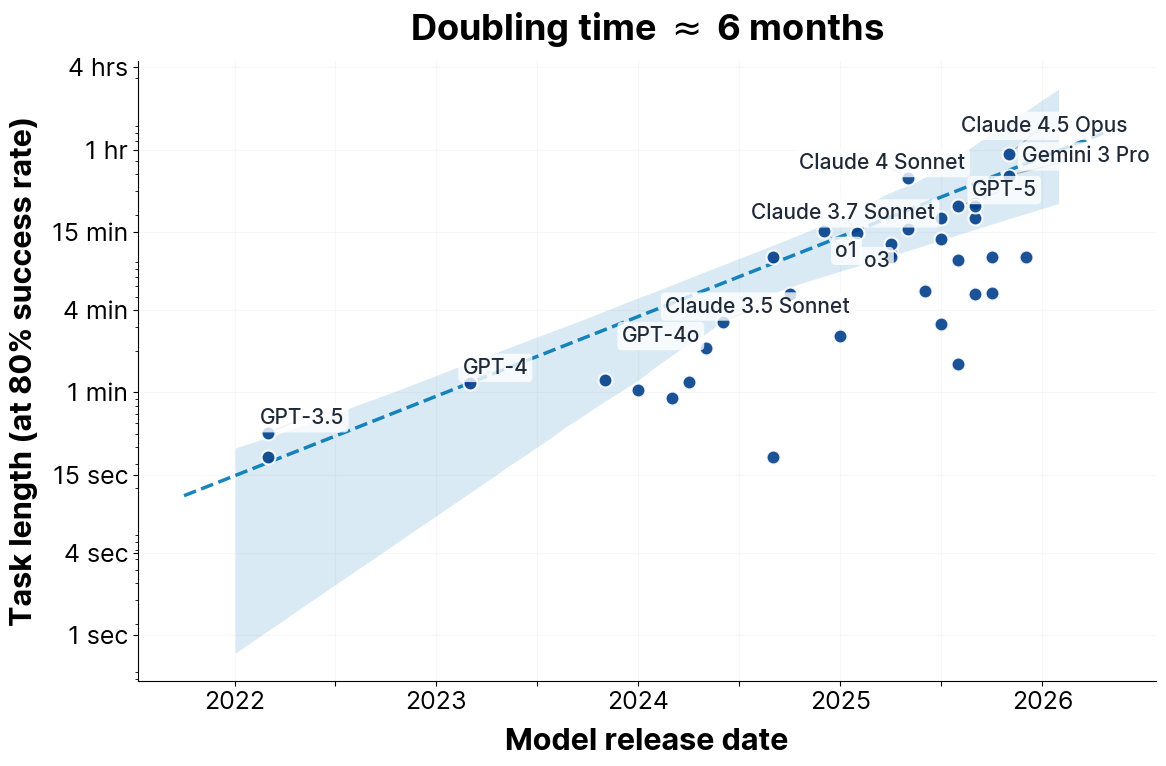

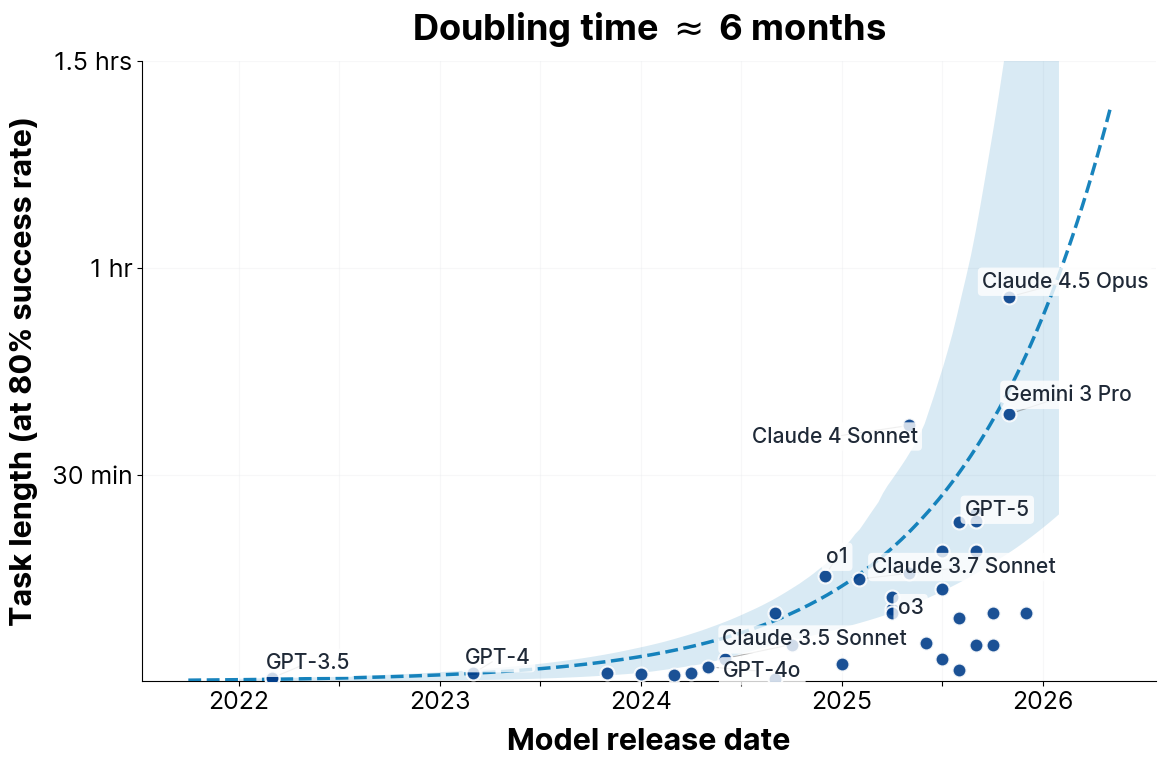

In [28]:
def plot_task_length_forecasts_p80(model_to_success_prob_df, model_maps=MODEL_MAPS, n_bootstrap=500, prefix="ability_forecast", window=15, color="blue"):
    """Plot task length forecasts at 80% success rate threshold."""
    threshold = 0.8

    # For each model, find difficulty_b at 80% success rate
    model_names = model_to_success_prob_df["model_name"].unique()
    results = []

    for model_name in model_names:
        subset = model_to_success_prob_df[model_to_success_prob_df['model_name'] == model_name].copy()
        subset = subset.sort_values('difficulty_b')
        if len(subset) < window:
            continue

        logits = subset['discrimination_a'] * (subset['ability'] - subset['difficulty_b'])
        mean_logit = logits.rolling(window=window, center=True, min_periods=5).mean()
        x = subset['difficulty_b'].to_numpy()
        y = (1 / (1 + np.exp(-mean_logit))).to_numpy()
        mask = ~np.isnan(y)
        x_valid, y_valid = x[mask], y[mask]

        if len(x_valid) == 0 or y_valid.max() < threshold:
            continue

        # Find crossing point
        crossing_indices = []
        for i in range(len(y_valid) - 1):
            if y_valid[i] >= threshold > y_valid[i+1]:
                t = (threshold - y_valid[i]) / (y_valid[i+1] - y_valid[i])
                crossing_indices.append(x_valid[i] + t * (x_valid[i+1] - x_valid[i]))

        b_at_threshold = np.mean(crossing_indices) if crossing_indices else x_valid[np.argmin(np.abs(y_valid - threshold))]
        results.append({'model_name': model_name, 'release_time': subset['release_time'].iloc[0],
                        'ability': subset['ability'].iloc[0], 'difficulty_b_at_p80': b_at_threshold})

    fit_df = pd.DataFrame(results)
    fit_df["release_time"] = pd.to_datetime(fit_df["release_time"])
    fit_df["release_months_norm"] = fit_df["release_time"].dt.year * 12 + (fit_df["release_time"].dt.month - 1).astype(float)
    fit_df['predicted_minutes'] = predict_minutes_from_b(fit_df['difficulty_b_at_p80'].to_numpy())

    # Frontier selection
    fit_sorted = fit_df.sort_values("release_time")
    frontier_rows, best_so_far = [], -np.inf
    for _, row in fit_sorted.iterrows():
        if row["difficulty_b_at_p80"] > best_so_far + 0.2:
            frontier_rows.append(row)
            best_so_far = row["difficulty_b_at_p80"]
    frontier_df = pd.DataFrame(frontier_rows).reset_index(drop=True)

    x = frontier_df["release_months_norm"].to_numpy().astype(float)
    y = frontier_df['difficulty_b_at_p80'].to_numpy().astype(float)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    n = len(x)
    if n < 2:
        print("Not enough frontier points!")
        return

    reg_ = stats.linregress(x, y)
    x_fit = np.linspace(2021 * 12 + 9, 2026 * 12 + 4, 200)
    y_fit = reg_.intercept + reg_.slope * x_fit

    rng = np.random.default_rng(42)
    bootstrap_fits = np.zeros((n_bootstrap, len(x_fit)))
    bootstrap_slopes = np.zeros(n_bootstrap)
    for i in range(n_bootstrap):
        indices = rng.choice(n, size=n, replace=True)
        reg_boot = stats.linregress(x[indices], y[indices])
        bootstrap_fits[i] = reg_boot.intercept + reg_boot.slope * x_fit
        bootstrap_slopes[i] = reg_boot.slope

    y_ci_lower = np.percentile(bootstrap_fits, 2.5, axis=0)
    y_ci_upper = np.percentile(bootstrap_fits, 97.5, axis=0)
    slope_ci = [np.percentile(bootstrap_slopes, 2.5), np.percentile(bootstrap_slopes, 97.5)]

    delta_b = np.log(2.0) / np.log(2.26)
    doubling_months = delta_b / reg_.slope
    doubling_ci = [delta_b / slope_ci[1], delta_b / slope_ci[0]]
    print(f"P80 - Slope: {reg_.slope:.4f} [{slope_ci[0]:.4f}, {slope_ci[1]:.4f}]")
    print(f"P80 - Doubling time: {doubling_months:.1f} months [{doubling_ci[0]:.1f}, {doubling_ci[1]:.1f}]")

    PRIMARY = "#0077b6" if color == "blue" else "#059669"
    POINT = "#023e8a" if color == "blue" else "#047857"
    x_data_min, x_data_max = fit_df["release_months_norm"].min(), fit_df["release_months_norm"].max()
    ci_mask = (x_fit >= x_data_min - 2) & (x_fit <= x_data_max + 2)
    date_xticks = [2022*12, 2022*12+6, 2023*12, 2023*12+6, 2024*12, 2024*12+6, 2025*12, 2025*12+6, 2026*12]
    date_labels = ["2022", "", "2023", "", "2024", "", "2025", "", "2026"]

    plt.rcParams.update({'font.size': 18, 'axes.titlesize': 26, 'axes.labelsize': 22, 'xtick.labelsize': 18, 'ytick.labelsize': 18})

    for scale in ['log', 'linear']:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(fit_df["release_months_norm"], fit_df["predicted_minutes"], s=100, color=POINT, edgecolors='white', linewidths=1.5, alpha=0.9, zorder=4)

        texts = []
        for mn, ml in model_maps.items():
            if mn not in fit_df["model_name"].values:
                continue
            r = fit_df[fit_df["model_name"] == mn].iloc[0]
            texts.append(ax.text(r["release_months_norm"], r["predicted_minutes"], ml, fontsize=15, fontweight='medium', ha="center", va="bottom", color='#1f2937', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.8), zorder=10))

        y_fit_min = predict_minutes_from_b(y_fit)
        ax.plot(x_fit, y_fit_min, color=PRIMARY, linestyle="--", linewidth=2.5, alpha=0.9, zorder=3)
        ax.fill_between(x_fit[ci_mask], predict_minutes_from_b(y_ci_lower[ci_mask]), predict_minutes_from_b(y_ci_upper[ci_mask]), color=PRIMARY, alpha=0.15, linewidth=0, zorder=1)

        ax.set_xticks(date_xticks)
        ax.set_xticklabels(date_labels)
        ax.set_xlabel("Model release date", fontsize=22, fontweight='bold', labelpad=10)
        ax.set_ylabel(f"Task length (at {int(threshold*100)}% success rate)", fontsize=22, fontweight='bold', labelpad=10)
        ax.set_title(f"Doubling time $\\approx$ {doubling_months:.0f} months", fontsize=26, fontweight='bold', pad=15)
        ax.grid(True, which="major", linestyle="-", alpha=0.3, color='#e5e7eb', zorder=0)
        ax.set_axisbelow(True)
        ax.minorticks_off()

        if scale == 'log':
            ax.set_yscale('log')
            yticks = [1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60]
            ax.set_yticks(yticks)
            ax.set_yticklabels(["1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs"])
        else:
            ax.set_yticks([30, 60, 90])
            ax.set_yticklabels(["30 min", "1 hr", "1.5 hrs"])
            ax.set_ylim(0, 90)

        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.6, lw=0.8, shrinkA=5, shrinkB=5), 
                    expand_points=(2.0, 2.0), expand_text=(1.5, 1.5), force_points=(1.0, 1.0), force_text=(0.8, 0.8), only_move={'points': 'y', 'texts': 'xy'})
        fig.tight_layout()
        fig.savefig(plots_dir / f"{prefix}_{scale}_scale_p80.pdf", dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()


plot_task_length_forecasts_p80(all_models_to_success_prob_df, n_bootstrap=2000)